In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf

from tensorflow import keras
from keras import layers

2023-06-30 15:16:20.611817: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-06-30 15:16:20.653400: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-06-30 15:16:20.654017: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-30 15:16:21.483827: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
train_data_all = pd.read_csv("../data/train.csv")

In [3]:
train_data_all.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
# replace missing values in training data

train_data_filtered = pd.DataFrame()

for column in train_data_all.columns:
    dtype = train_data_all[column].dtype

    # use -1 for numerical data, "NA" for strings (objects)
    if dtype == "int64" or dtype == "float64":
        val = -1
    else:
        val = "NA"
    train_data_filtered[column] = train_data_all[column].fillna(val)

# ignore id, name, and ticket (for now)
train_data_filtered.drop(columns=["PassengerId", "Name", "Ticket"], inplace=True)

# convert age to float for treatment as continuous variable
train_data_filtered["Age"] = train_data_filtered["Age"].astype('float64')

In [5]:
# split into training and validation datasets

val_frac = .2
val_df = train_data_filtered.sample(frac=0.2)
train_df = train_data_filtered.drop(val_df.index)

In [6]:
# convert pd DataFrame to tf Dataset labelled with answers
def dataframe_to_dataset(df):
    
    df = df.copy()
    labels = df.pop("Survived")
    ds = tf.data.Dataset.from_tensor_slices((dict(df), labels))
    ds = ds.shuffle(buffer_size=len(df))

    return ds

In [7]:
# convert to Datasets
train_ds = dataframe_to_dataset(train_df)
val_ds = dataframe_to_dataset(val_df)

# batch Datasets
batch_size = 32
train_ds = train_ds.batch(batch_size)
val_ds = val_ds.batch(batch_size)

2023-06-30 15:16:26.498212: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-06-30 15:16:26.498732: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1956] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [38]:
from tensorflow.keras.layers import StringLookup

def encode_string_feature(feature, name, feature_ds):

    lookup = StringLookup(output_mode="one_hot")
    lookup.adapt(feature_ds)

    return lookup(feature)

In [39]:
from tensorflow.keras.layers import IntegerLookup

def encode_integer_feature(feature, name, feature_ds):

    lookup = IntegerLookup(output_mode="one_hot")
    lookup.adapt(feature_ds)

    return lookup(feature)

In [40]:
from tensorflow.keras.layers import Normalization

def encode_float_feature(feature, name, feature_ds):

    normalizer = Normalization()
    normalizer.adapt(feature_ds)
    
    return normalizer(feature)

In [41]:
def encode_feature(feature, name, dataset):

    # construct dataset with only given feature
    feature_ds = dataset.map(lambda x, y: x[name])
    feature_ds = feature_ds.map(lambda x: tf.expand_dims(x, -1))

    # build encoder based on feature dtype
    dtype = feature_ds.element_spec.dtype

    if dtype == tf.string:
        encoded_feature = encode_string_feature(feature, name, feature_ds)
    elif dtype == tf.int64:
        encoded_feature = encode_integer_feature(feature, name, feature_ds)
    elif dtype == tf.float64:
        encoded_feature = encode_float_feature(feature, name, feature_ds)
    else:
        print("Unexpected datatype: " + str(dtype))
        encoded_feature = "AAAAaaaAA"

    return encoded_feature


In [42]:
train_ds.element_spec[0]

{'Pclass': TensorSpec(shape=(None,), dtype=tf.int64, name=None),
 'Sex': TensorSpec(shape=(None,), dtype=tf.string, name=None),
 'Age': TensorSpec(shape=(None,), dtype=tf.float64, name=None),
 'SibSp': TensorSpec(shape=(None,), dtype=tf.int64, name=None),
 'Parch': TensorSpec(shape=(None,), dtype=tf.int64, name=None),
 'Fare': TensorSpec(shape=(None,), dtype=tf.float64, name=None),
 'Cabin': TensorSpec(shape=(None,), dtype=tf.string, name=None),
 'Embarked': TensorSpec(shape=(None,), dtype=tf.string, name=None)}

In [43]:
# build input layers based on feature specs from ds

all_inputs = dict()

features = train_ds.element_spec[0]

for name, spec in features.items():
    all_inputs[name] = keras.Input(
        shape=(1,),
        name=name,
        dtype=spec.dtype
    )

In [44]:
# build individual encoding layers for each feature

encodings = dict()

for name, spec in features.items():
    encodings[name] = encode_feature(
        all_inputs[name],
        name,
        train_ds
    )

# concatenate feature encodings

all_features = layers.concatenate(encodings.values())

2023-06-30 15:34:39.463059: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_7' with dtype int64 and shape [713]
	 [[{{node Placeholder/_7}}]]
2023-06-30 15:34:39.463510: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_8' with dtype int64 and shape [713]
	 [[{{node Placeholder/_8}}]]
2023-06-30 15:34:39.549564: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int64 and shape [713]
	 [[

In [45]:
# build dense network from encoded features to predicted survival

x = layers.Dense(32, activation="relu")(all_features)
x = layers.Dropout(0.5)(x)

output = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(all_inputs.values(), output)
model.compile("adam", "binary_crossentropy", metrics=["accuracy"])

In [46]:
all_inputs

{'Pclass': <KerasTensor: shape=(None, 1) dtype=int64 (created by layer 'Pclass')>,
 'Sex': <KerasTensor: shape=(None, 1) dtype=string (created by layer 'Sex')>,
 'Age': <KerasTensor: shape=(None, 1) dtype=float64 (created by layer 'Age')>,
 'SibSp': <KerasTensor: shape=(None, 1) dtype=int64 (created by layer 'SibSp')>,
 'Parch': <KerasTensor: shape=(None, 1) dtype=int64 (created by layer 'Parch')>,
 'Fare': <KerasTensor: shape=(None, 1) dtype=float64 (created by layer 'Fare')>,
 'Cabin': <KerasTensor: shape=(None, 1) dtype=string (created by layer 'Cabin')>,
 'Embarked': <KerasTensor: shape=(None, 1) dtype=string (created by layer 'Embarked')>}

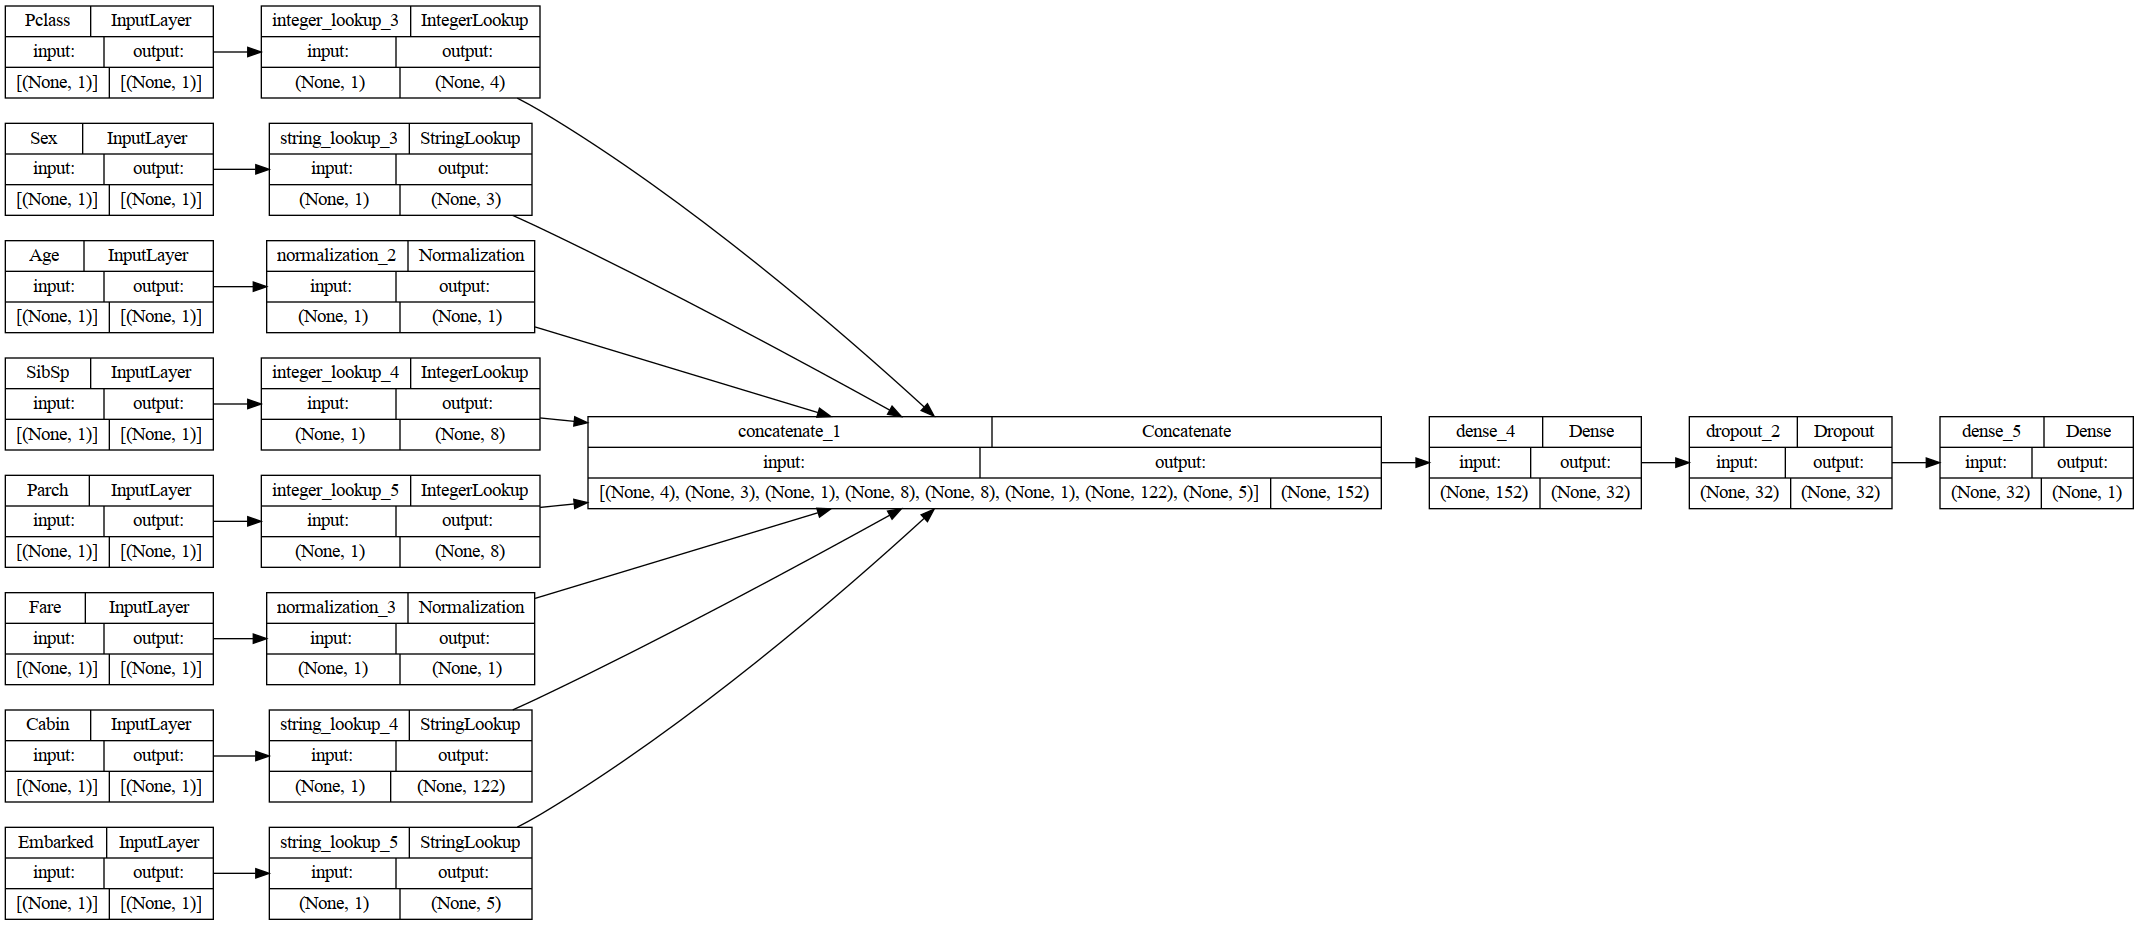

In [47]:
keras.utils.plot_model(model, show_shapes=True, rankdir="LR")

In [48]:
# train model
model.fit(train_ds, epochs=50)

Epoch 1/50


2023-06-30 15:34:43.537769: W tensorflow/core/framework/op_kernel.cc:1807] OP_REQUIRES failed at cast_op.cc:121 : UNIMPLEMENTED: Cast string to double is not supported


UnimplementedError: Graph execution error:

Detected at node 'model_2/Cast_1' defined at (most recent call last):
    File "<frozen runpy>", line 198, in _run_module_as_main
    File "<frozen runpy>", line 88, in _run_code
    File "/home/ben/.pyenv/versions/3.11.3/envs/kaggle/lib/python3.11/site-packages/ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "/home/ben/.pyenv/versions/3.11.3/envs/kaggle/lib/python3.11/site-packages/traitlets/config/application.py", line 1043, in launch_instance
      app.start()
    File "/home/ben/.pyenv/versions/3.11.3/envs/kaggle/lib/python3.11/site-packages/ipykernel/kernelapp.py", line 728, in start
      self.io_loop.start()
    File "/home/ben/.pyenv/versions/3.11.3/envs/kaggle/lib/python3.11/site-packages/tornado/platform/asyncio.py", line 195, in start
      self.asyncio_loop.run_forever()
    File "/home/ben/.pyenv/versions/3.11.3/lib/python3.11/asyncio/base_events.py", line 607, in run_forever
      self._run_once()
    File "/home/ben/.pyenv/versions/3.11.3/lib/python3.11/asyncio/base_events.py", line 1922, in _run_once
      handle._run()
    File "/home/ben/.pyenv/versions/3.11.3/lib/python3.11/asyncio/events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "/home/ben/.pyenv/versions/3.11.3/envs/kaggle/lib/python3.11/site-packages/ipykernel/kernelbase.py", line 513, in dispatch_queue
      await self.process_one()
    File "/home/ben/.pyenv/versions/3.11.3/envs/kaggle/lib/python3.11/site-packages/ipykernel/kernelbase.py", line 502, in process_one
      await dispatch(*args)
    File "/home/ben/.pyenv/versions/3.11.3/envs/kaggle/lib/python3.11/site-packages/ipykernel/kernelbase.py", line 409, in dispatch_shell
      await result
    File "/home/ben/.pyenv/versions/3.11.3/envs/kaggle/lib/python3.11/site-packages/ipykernel/kernelbase.py", line 729, in execute_request
      reply_content = await reply_content
    File "/home/ben/.pyenv/versions/3.11.3/envs/kaggle/lib/python3.11/site-packages/ipykernel/ipkernel.py", line 422, in do_execute
      res = shell.run_cell(
    File "/home/ben/.pyenv/versions/3.11.3/envs/kaggle/lib/python3.11/site-packages/ipykernel/zmqshell.py", line 540, in run_cell
      return super().run_cell(*args, **kwargs)
    File "/home/ben/.pyenv/versions/3.11.3/envs/kaggle/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3009, in run_cell
      result = self._run_cell(
    File "/home/ben/.pyenv/versions/3.11.3/envs/kaggle/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3064, in _run_cell
      result = runner(coro)
    File "/home/ben/.pyenv/versions/3.11.3/envs/kaggle/lib/python3.11/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "/home/ben/.pyenv/versions/3.11.3/envs/kaggle/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3269, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "/home/ben/.pyenv/versions/3.11.3/envs/kaggle/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3448, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "/home/ben/.pyenv/versions/3.11.3/envs/kaggle/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3508, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "/tmp/ipykernel_12218/2021567895.py", line 2, in <module>
      model.fit(train_ds, epochs=50)
    File "/home/ben/.pyenv/versions/3.11.3/envs/kaggle/lib/python3.11/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/home/ben/.pyenv/versions/3.11.3/envs/kaggle/lib/python3.11/site-packages/keras/engine/training.py", line 1685, in fit
      tmp_logs = self.train_function(iterator)
    File "/home/ben/.pyenv/versions/3.11.3/envs/kaggle/lib/python3.11/site-packages/keras/engine/training.py", line 1284, in train_function
      return step_function(self, iterator)
    File "/home/ben/.pyenv/versions/3.11.3/envs/kaggle/lib/python3.11/site-packages/keras/engine/training.py", line 1268, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/home/ben/.pyenv/versions/3.11.3/envs/kaggle/lib/python3.11/site-packages/keras/engine/training.py", line 1249, in run_step
      outputs = model.train_step(data)
    File "/home/ben/.pyenv/versions/3.11.3/envs/kaggle/lib/python3.11/site-packages/keras/engine/training.py", line 1050, in train_step
      y_pred = self(x, training=True)
    File "/home/ben/.pyenv/versions/3.11.3/envs/kaggle/lib/python3.11/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/home/ben/.pyenv/versions/3.11.3/envs/kaggle/lib/python3.11/site-packages/keras/engine/training.py", line 558, in __call__
      return super().__call__(*args, **kwargs)
    File "/home/ben/.pyenv/versions/3.11.3/envs/kaggle/lib/python3.11/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/home/ben/.pyenv/versions/3.11.3/envs/kaggle/lib/python3.11/site-packages/keras/engine/base_layer.py", line 1145, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "/home/ben/.pyenv/versions/3.11.3/envs/kaggle/lib/python3.11/site-packages/keras/utils/traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "/home/ben/.pyenv/versions/3.11.3/envs/kaggle/lib/python3.11/site-packages/keras/engine/functional.py", line 512, in call
      return self._run_internal_graph(inputs, training=training, mask=mask)
    File "/home/ben/.pyenv/versions/3.11.3/envs/kaggle/lib/python3.11/site-packages/keras/engine/functional.py", line 651, in _run_internal_graph
      y = self._conform_to_reference_input(y, ref_input=x)
    File "/home/ben/.pyenv/versions/3.11.3/envs/kaggle/lib/python3.11/site-packages/keras/engine/functional.py", line 748, in _conform_to_reference_input
      tensor = tf.cast(tensor, dtype=ref_input.dtype)
Node: 'model_2/Cast_1'
Cast string to double is not supported
	 [[{{node model_2/Cast_1}}]] [Op:__inference_train_function_6811]